In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from joblib import delayed,Parallel

# FUNCTION DEFINITION

In [2]:
def create_graph(N,min_degree,etas,initialize=True,G=None):
    #CHECK THE INITIAL CONDITIONS
    assert N >0, "Variable N should be bigger than Zero"
    assert N == len(etas),"Array of Nodes and Eta Values Should be the same length"
    assert min_degree >0,"Minimum degree of graph should be bigger than Zero" 
    assert sum(etas) >0,"Sum of Eta values should be bigger than zero"
    # assert (initialize AND graph == None) OR (!initialize AND graph != None),"Graph either should be initialized or Given"

    #CREATE A FULLY CONNECTED GRAPH AS THE BASIS
    if initialize:
        G=nx.complete_graph(min_degree+1)
    
    n_nodes = len(list(G.nodes()))

    #ADD ALL THE REMAINING NODES TO THE GRAPH (IT'S MORE EFFICIENT THAN ADDING IT SEQUENTIALLY)
    G.add_nodes_from(np.arange(n_nodes,N))

    #GET THE DEGREE DISTRIBUTION OF THE NODES 
    degree_dst=np.array([G.degree(node) for node in range(N)])

    #GET THE LIST OF AVAILABLE NODES (NODES WHICH ARE CONNECTED)
    available = [x for x in range(n_nodes)]

    #ADD THE EDGES SEQUENTIALLY
    for i in range(n_nodes,N):

        #CALCULATE THE FITNESS FUNCTION BASED ON DEGREE AND ETA VALUE
        fitness=np.multiply(degree_dst[:i],etas[:i])

        #CALCULATE THE PROBABILITY OF EACH NODE
        fitness_prob=dict(zip(available,fitness/fitness.sum()))

        #SELECT RANDOM NODES BASED ON THOSE PROBABILITY
        selected = np.random.choice(available,min_degree,p=list(fitness_prob.values()),replace=False)

        #ADD THE EDGES TO THE GRAPH
        e = zip([i for _ in range(min_degree)],selected)

        G.add_edges_from(e)

        #UPDATE THE DEGREE DISTRIBUTION BASED ON THE ADDED EDGES
        degree_dst[i]+=min_degree
        degree_dst[selected]+=1
        
        #ADD THE NEW NODE TO THE AVAILABLE LIST
        available.append(i)
    return G

In [3]:
#A FUNCTION FOR CALCULATING GAMMA VARIABLE BASED ON DEGREE DISTRIBUTION
def calc_gamma(G):

    #GET DEGREE DISTRIBUTION FROM THE GRAPH
    degree_dst=[G.degree(node) for node in G.nodes()]

    #CALCULATE THE MINIMUM AND MAXIMUM DEGREE AND NUMBER OF NODES FROM DEGREE DISTRIBUTION
    k_max = np.max(degree_dst)

    k_min = np.min(degree_dst)

    N = len(degree_dst)

    #CALCULATE GAMMA BASED ON THE POWERLAW FORMULA
    gamma = (np.log(N)/np.log(k_max/k_min)) + 1

    return gamma
#A FUNCTION FOR CALCULATING AVERAGE DEGREE BASED ON DEGREE DISTRIBUTION

def calc_average_degree(G):

    degree_dst=[G.degree(node) for node in G.nodes()]
    
    return np.sum(degree_dst) / len(degree_dst)

#A FUNCTION FOR CALCULATING AVERAGE DISTANCE

def calc_average_distance(G,sampling_ratio):
    assert sampling_ratio > 0 and sampling_ratio <=1,"Sampling ratio must be between 0 and 1"
    s=0
    nodes = list(G.nodes)
    sample_size = int(sampling_ratio*len(nodes))
    d=0
    #SELECT RANDOM PAIRS OF NODES IN GRAPH AND SUM THEIR DISTANCE 
    for i in range(sample_size):
        random_nodes = np.random.choice(nodes, 2,replace=False)
        d+= nx.shortest_path_length(G,random_nodes[0],random_nodes[1])
    #AVERAGE SUM OF DISTANCE 
    return d/sample_size

In [4]:
#CREATE A CLASS FOR CREATING GRAPH
class graph():
    def __init__(self,N,gamma,min_degree,init_graph=True,G=None,sampling_ratio=0.05):
        assert gamma in [2,2.5,3,3.5],"Gamma Should be in [2,2.5,3,3.5]"
        assert N > 0,"Variable N should be bigger than Zero"
        assert min_degree > 0,"Minimum Degree should be bigger than Zero"
        self.N = N
        self.min_degree = min_degree
        self.init_graph =init_graph
        self.G = G
        self.sampling_ratio = sampling_ratio
        #SET ETA VALUES ACCORDINGLY TO GET THE INTENDED GAMMA VALUE
        if gamma ==2:
            self.etas = [(0) for _ in range(N)]
            self.etas[0] = 0.1
            self.etas[1] = 0.1
        if gamma ==2.5:
            self.etas = [(1e-1) for _ in range(N)]
            self.etas[0] = 0.15
        if gamma ==3:
            self.etas = [(1e-1) for _ in range(N)]
        if gamma ==3.5:
            self.etas=np.linspace(start=1e-1,stop=1e10,num=N)
    def run(self):
        #CREATE THE GRAPH AND CALCULATE GAMMA,AVERAGE DISTANCE AND AVERAGE DEGREE
        self.G = create_graph(self.N,self.min_degree,self.etas,initialize=self.init_graph,G=self.G)
        gamma = calc_gamma(self.G)
        average_distance = calc_average_distance(self.G,self.sampling_ratio)
        average_degree = calc_average_degree(self.G)
        return self.G,gamma,average_distance,average_degree

# Graph Creation

gamma =2

In [57]:
G = graph(100,gamma=2,min_degree=2,sampling_ratio=1)
results = np.array(Parallel(n_jobs=4)(delayed(G.run)() for x in range(20)),dtype=object)
np.save('./N_100_g_2',results)

G = [graph(1000,gamma=2,min_degree=2,init_graph=False,G=x,sampling_ratio=0.05) for x in results[:,0]]
results = np.array(Parallel(n_jobs=4)(delayed(x.run)() for x in G),dtype=object)
np.save('./N_1000_g_2',results)

G = [graph(10000,gamma=2,min_degree=2,init_graph=False,G=x,sampling_ratio=0.05) for x in results[:,0]]
results = np.array(Parallel(n_jobs=4)(delayed(x.run)() for x in G),dtype=object)
np.save('./N_10000_g_2',results)

G = [graph(100000,gamma=2,min_degree=2,init_graph=False,G=x,sampling_ratio=0.05) for x in results[:,0]][0]
results = np.array(G.run(),dtype=object)
np.save('./N_100000_g_2',results)


2<gamma<3

In [ ]:
G = graph(100,gamma=2.5,min_degree=2,sampling_ratio=1)
results = np.array(Parallel(n_jobs=4)(delayed(G.run)() for x in range(20)),dtype=object)
np.save('./N_100_g_2.5',results)

G = [graph(1000,gamma=2.5,min_degree=2,init_graph=False,G=x,sampling_ratio=0.05) for x in results[:,0]]
results = np.array(Parallel(n_jobs=4)(delayed(x.run)() for x in G),dtype=object)
np.save('./N_1000_g_2.5',results)

G = [graph(10000,gamma=2.5,min_degree=2,init_graph=False,G=x,sampling_ratio=0.05) for x in results[:,0]]
results = np.array(Parallel(n_jobs=4)(delayed(x.run)() for x in G),dtype=object)
np.save('./N_10000_g_2.5',results)

G = [graph(100000,gamma=2.5,min_degree=2,init_graph=False,G=x,sampling_ratio=0.05) for x in results[:,0]][0]
results = np.array(G.run(),dtype=object)
np.save('./N_100000_g_2.5',results)


gamma =3 

In [196]:
G = graph(100,gamma=3,min_degree=2,sampling_ratio=1)
results = np.array(Parallel(n_jobs=4)(delayed(G.run)() for x in range(20)),dtype=object)
np.save('./N_100_g_3',results)

G = [graph(1000,gamma=3,min_degree=2,init_graph=False,G=x,sampling_ratio=0.05) for x in results[:,0]]
results = np.array(Parallel(n_jobs=4)(delayed(x.run)() for x in G),dtype=object)
np.save('./N_1000_g_3',results)

G = [graph(10000,gamma=3,min_degree=2,init_graph=False,G=x,sampling_ratio=0.05) for x in results[:,0]]
results = np.array(Parallel(n_jobs=4)(delayed(x.run)() for x in G),dtype=object)
np.save('./N_10000_g_3',results)

G = [graph(100000,gamma=3,min_degree=2,init_graph=False,G=x,sampling_ratio=0.05) for x in results[:,0]][0]
results = np.array(G.run(),dtype=object)
np.save('./N_100000_g_3',results)


gamma > 3

In [ ]:
G = graph(100,gamma=3.5,min_degree=2,sampling_ratio=1)
results = np.array(Parallel(n_jobs=4)(delayed(G.run)() for x in range(20)),dtype=object)
np.save('./N_100_g_3.5',results)

G = [graph(1000,gamma=3.5,min_degree=2,init_graph=False,G=x,sampling_ratio=0.05) for x in results[:,0]]
results = np.array(Parallel(n_jobs=4)(delayed(x.run)() for x in G),dtype=object)
np.save('./N_1000_g_3.5',results)

G = [graph(10000,gamma=3.5,min_degree=2,init_graph=False,G=x,sampling_ratio=0.05) for x in results[:,0]]
results = np.array(Parallel(n_jobs=4)(delayed(x.run)() for x in G),dtype=object)
np.save('./N_10000_g_3.5',results)

G = [graph(100000,gamma=3.5,min_degree=2,init_graph=False,G=x,sampling_ratio=0.05) for x in results[:,0]][0]
results = np.array(G.run(),dtype=object)
np.save('./N_100000_g_3.5',results)


# Results:

In [7]:
#LOADING THE SAVED RESULTS
N= [100,1000,10000,100000]
gamma = [2,2.5,3,3.5]
results = []
for i in gamma:
    for j in N:
        results.append(np.load(f'./N_{j}_g_{i}.npy',allow_pickle=True))
        print(i,j)

2 100
2 1000
2 10000
2 100000
2.5 100
2.5 1000
2.5 10000
2.5 100000
3 100
3 1000
3 10000
3 100000
3.5 100
3.5 1000
3.5 10000
3.5 100000


In [8]:
#CALCULATING AVERAGE GAMMA FOR EACH GRAPH TYPE
gamma_2={}
N=[100,1000,10000]
for i in range(0,3):
    gamma_2[N[i]] = np.mean(results[i][:,1])
gamma_2[100000] = results[3][1]

gamma_2_5={}
for i in range(4,7):
    gamma_2_5[N[i-4]] = np.mean(results[i][:,1])
gamma_2_5[100000] = results[7][1]

gamma_3={}
for i in range(8,11):
    gamma_3[N[i-8]] = np.mean(results[i][:,1])
gamma_3[100000] = results[11][1]

gamma_3_5={}
for i in range(12,15):
    gamma_3_5[N[i-12]] = np.mean(results[i][:,1])
gamma_3_5[100000] = results[15][1]

In [9]:
#CALCULATING AVERAGE DISTANCE FOR EACH GRAPH TYPE
d_2={}
N=[100,1000,10000]
for i in range(0,3):
    d_2[N[i]] = np.mean(results[i][:,2])
d_2[100000] = results[3][2]

d_2_5={}
for i in range(4,7):
    d_2_5[N[i-4]] = np.mean(results[i][:,2])
d_2_5[100000] = results[7][2]

d_3={}
for i in range(8,11):
    d_3[N[i-8]] = np.mean(results[i][:,2])
d_3[100000] = results[11][2]

d_3_5={}
for i in range(12,15):
    d_3_5[N[i-12]] = np.mean(results[i][:,2])
d_3_5[100000] = results[15][2]

In [10]:
#CALCULATING AVERAGE DEGREE FOR EACH GRAPH TYPE
k_2={}
N=[100,1000,10000]
for i in range(0,3):
    k_2[N[i]] = np.mean(results[i][:,3])
k_2[100000] = results[3][3]

k_2_5={}
for i in range(4,7):
    k_2_5[N[i-4]] = np.mean(results[i][:,3])
k_2_5[100000] = results[7][3]

k_3={}
for i in range(8,11):
    k_3[N[i-8]] = np.mean(results[i][:,3])
k_3[100000] = results[11][3]

k_3_5={}
for i in range(12,15):
    k_3_5[N[i-12]] = np.mean(results[i][:,3])
k_3_5[100000] = results[15][3]

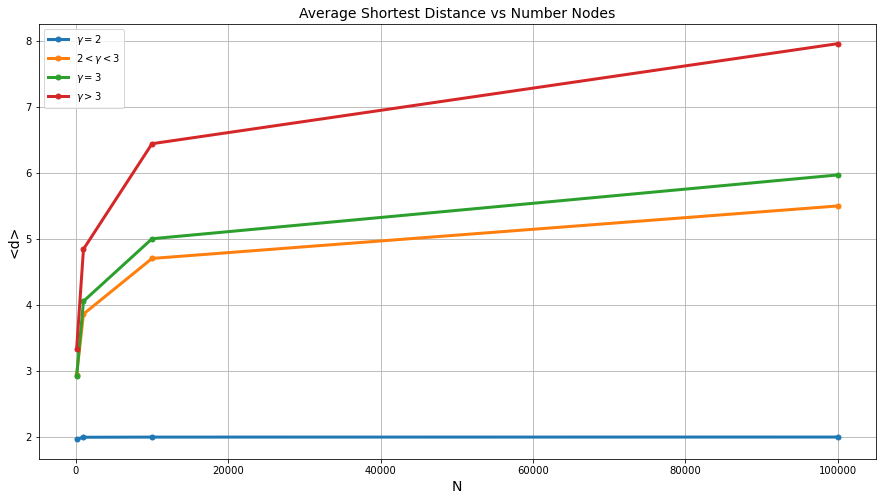

In [21]:
plt.figure(figsize=(15,8))
plt.plot(d_2.keys(),d_2.values(),linewidth=3,label=r'$\gamma = 2$',marker='o',markersize=5)
plt.plot(d_2_5.keys(),d_2_5.values(),linewidth=3,label=r'$2<\gamma<3$',marker='o',markersize=5)
plt.plot(d_3.keys(),d_3.values(),linewidth=3,label=r'$\gamma = 3$',marker='o',markersize=5)
plt.plot(d_3_5.keys(),d_3_5.values(),linewidth=3,label=r'$\gamma > 3$',marker='o',markersize=5)
plt.ylabel('<d>',size=14)
plt.xlabel("N",size=14)
plt.title("Average Shortest Distance vs Number Nodes",size=14)
plt.legend()
plt.grid()
plt.show()

# Comparing The Empricial Results with Estimated Values

In [12]:
#GRAPHS WITH GAMMA=2
f_2=[]
for i in range(4):
    f_2.append(np.abs((2)/list(d_2.values())[i]))
f_2

[1.015228426395939, 1.0015022533800702, 1.0003000900270083, 1.0]

In [13]:
#GRAPHS WITH GAMMA = 3 
expected_d = [np.log(N)/np.log(np.log(N)) for N in [1e2,1e3,1e4,1e5]]
f_3=[]
for i in range(4):
    f_3.append(np.abs((expected_d[i])/list(d_3.values())[i]))
f_3

[1.0326965150277363, 0.8807910095076392, 0.828809453307034, 0.7890462394995635]

In [14]:
#GRAPHS WITH GAMMA BETWEEN 2 AND 3
expected_d = []
N=[1e2,1e3,1e4,1e5]
for i in range(4):
    expected_d.append(np.log(np.log(N[i])) / np.log(gamma_2_5[N[i]] - 1))
f_2_5=[]
for i in range(4):
    f_2_5.append((expected_d[i])/list(d_2_5.values())[i])
f_2_5

[1.0588716349053637,
 1.1193641050856205,
 1.1310719203554342,
 1.1593912375583217]

In [15]:
#GRAPHS WITH GAMMA BIGGER THAN 3
expected_d = [np.log(i) for i in N]
f_3_5=[]
for i in range(4):
    f_3_5.append((expected_d[i])/list(d_3_5.values())[i])
f_3_5

[1.3829339897862136, 1.4251609818407547, 1.429023206723792, 1.4462384072771184]

# PLOTTING DISTANCE DENSITY PLOT

In [226]:
def distance(G,sampling_ratio):
    assert sampling_ratio > 0 and sampling_ratio <=1,"Sampling ratio must be between 0 and 1"
    nodes = list(G.nodes)
    sample_size = int(sampling_ratio*len(nodes))
    d=[]
    #SELECT RANDOM PAIRS OF NODES IN GRAPH AND CALCULATE THEIR DISTANCE 
    for i in range(sample_size):
        random_nodes = np.random.choice(nodes, 2,replace=False)
        d.append(nx.shortest_path_length(G,random_nodes[0],random_nodes[1]))
    hist,bin_edge = np.histogram(d,bins=np.arange(13,step=2))
    return hist/len(d)

In [ ]:
d_100=[]
for i in [0,4,8,12]:
    d_100.append(distance(results[i][0][0],sampling_ratio=1))
d_1000=[]
for i in [1,5,9,13]:
    d_1000.append(distance(results[i][0][0],sampling_ratio=0.05))
d_10000=[]
for i in [2,6,10,14]:
    d_10000.append(distance(results[i][0][0],sampling_ratio=0.05))
d_100000=[]
for i in [3,7,11,15]:
    d_100000.append(distance(results[i][0],sampling_ratio=0.05))

bin_edge = [1, 3, 5, 7,9,11]

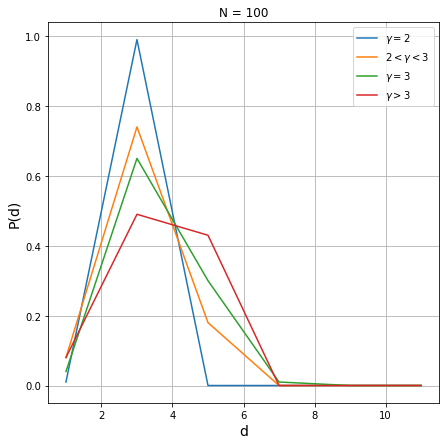

In [243]:
plt.figure(figsize=(7,7))
plt.plot(bin_edge,d_100[0],label=r'$\gamma=2$')
plt.plot(bin_edge,d_100[1],label=r'$2<\gamma<3$')
plt.plot(bin_edge,d_100[2],label=r'$\gamma=3$')
plt.plot(bin_edge,d_100[3],label=r'$\gamma>3$')
plt.ylabel('P(d)',size=14)
plt.xlabel('d',size=14)
plt.legend()
plt.title('N = 100')
plt.grid()
plt.show()

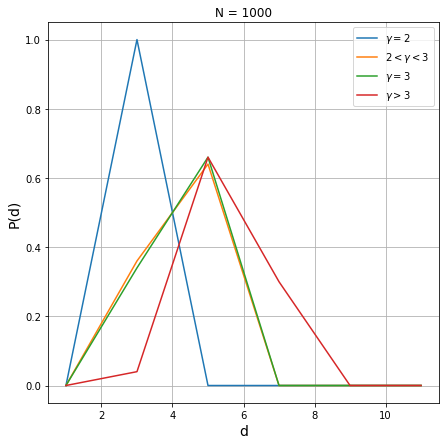

In [244]:
plt.figure(figsize=(7,7))
plt.plot(bin_edge,d_1000[0],label=r'$\gamma=2$')
plt.plot(bin_edge,d_1000[1],label=r'$2<\gamma<3$')
plt.plot(bin_edge,d_1000[2],label=r'$\gamma=3$')
plt.plot(bin_edge,d_1000[3],label=r'$\gamma>3$')
plt.ylabel('P(d)',size=14)
plt.xlabel('d',size=14)
plt.legend()
plt.title('N = 1000')
plt.grid()
plt.show()

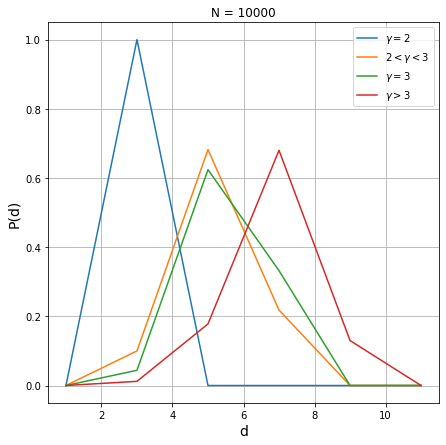

In [245]:
plt.figure(figsize=(7,7))
plt.plot(bin_edge,d_10000[0],label=r'$\gamma=2$')
plt.plot(bin_edge,d_10000[1],label=r'$2<\gamma<3$')
plt.plot(bin_edge,d_10000[2],label=r'$\gamma=3$')
plt.plot(bin_edge,d_10000[3],label=r'$\gamma>3$')
plt.ylabel('P(d)',size=14)
plt.xlabel('d',size=14)
plt.legend()
plt.title('N = 10000')
plt.grid()
plt.show()

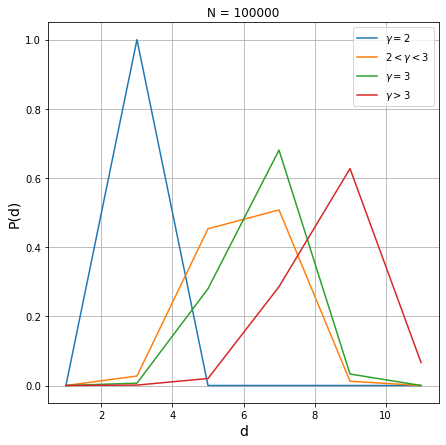

In [246]:
plt.figure(figsize=(7,7))
plt.plot(bin_edge,d_100000[0],label=r'$\gamma=2$')
plt.plot(bin_edge,d_100000[1],label=r'$2<\gamma<3$')
plt.plot(bin_edge,d_100000[2],label=r'$\gamma=3$')
plt.plot(bin_edge,d_100000[3],label=r'$\gamma>3$')
plt.ylabel('P(d)',size=14)
plt.xlabel('d',size=14)
plt.legend()
plt.title('N = 100000')
plt.grid()
plt.show()